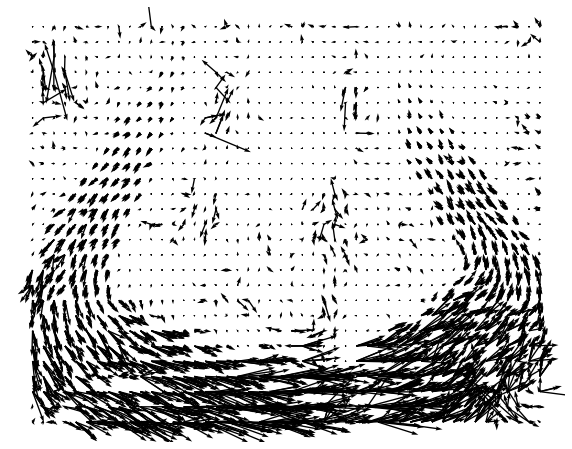

In [39]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))

# path = 'UCF_CrowdsDataset/2581-2_70.mov'
path = 'UCF_CrowdsDataset/3687-18_70.mov'

# The video feed is read in as a VideoCapture object
cap = cv.VideoCapture(path)
# ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
ret, first_frame = cap.read()
# Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
# Creates an image filled with zero intensities with the same dimensions as the frame
mask = np.zeros_like(first_frame)
# Sets image saturation to maximum
mask[..., 1] = 255

v=1
step = 15
while(cap.isOpened()):
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    ret, frame = cap.read()
    # Opens a new window and displays the input frame
    cv.imshow("input", frame)
    cv.imwrite('frame_i.png', frame)
    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Calculates dense optical flow by Farneback method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    px = np.arange(0, flow.shape[1], step)
    py = np.arange(flow.shape[0], -1, -step)
    dx = flow[::step, ::step, 0]
    dy = -flow[::step, ::step, 1]
    
    plt.quiver(px, py, dx, dy)
    plt.axis('off')
    name="optical_flow_"+str(v)+".jpg"
    plt.savefig(name, bbox_inches='tight', pad_inches=0)
    
    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    # Sets image hue according to the optical flow direction
    mask[..., 0] = angle * 180 / np.pi / 2
    # Sets image value according to the optical flow magnitude (normalized)
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
    # Converts HSV to RGB (BGR) color representation
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
    # Opens a new window and displays the output frame
    cv.imshow("dense optical flow", rgb)
    # Updates previous frame
    prev_gray = gray
    # Frames are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
# The following frees up resources and closes all windows
cap.release()
cv.destroyAllWindows()

In [40]:
img = cv.imread('frame_i.png')
img.shape

(404, 720, 3)

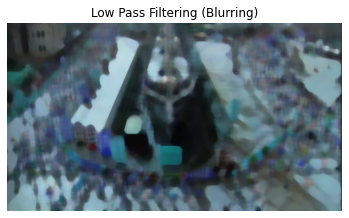

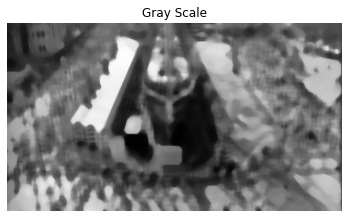

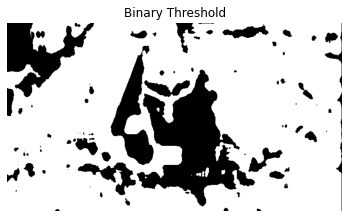

In [41]:
# Blurring
img_blur = cv2.medianBlur(src=img, ksize=15)
plt.figure(), plt.title("Low Pass Filtering (Blurring)"), plt.imshow(img_blur), plt.axis("off");

# Gray Scale
img_gray = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
plt.figure(), plt.title("Gray Scale"), plt.imshow(img_gray, cmap="gray"), plt.axis("off");

# Binary Threshold
ret, img_thres = cv2.threshold(src=img_gray, thresh=65, maxval=255, type=cv2.THRESH_BINARY)
plt.figure(), plt.title("Binary Threshold"), plt.imshow(img_thres, cmap="gray"), plt.axis("off");

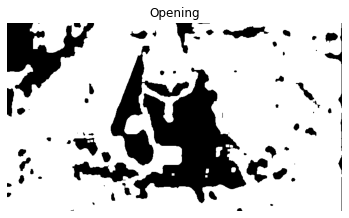

In [42]:
kernel = np.ones((3,3), np.uint8)

opening = cv2.morphologyEx(coin_thres, cv2.MORPH_OPEN, kernel=kernel, iterations=2)

plt.figure(), plt.title("Opening"), plt.imshow(opening, cmap="gray"), plt.axis("off");

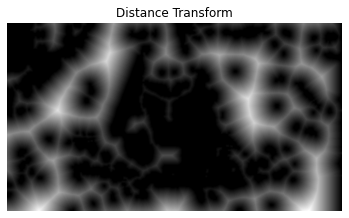

In [43]:
dist_transform = cv2.distanceTransform(src=opening, distanceType=cv2.DIST_L2, maskSize=5)

plt.figure(), plt.title("Distance Transform"), plt.imshow(dist_transform, cmap="gray"), plt.axis("off");

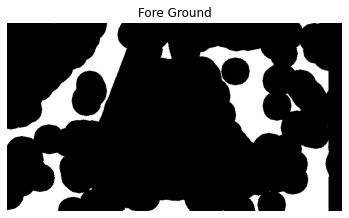

In [44]:
ret, sure_foreground = cv2.threshold(src=dist_transform, thresh=0.4*np.max(dist_transform), maxval=255, type=0)

plt.figure(), plt.title("Fore Ground"), plt.imshow(sure_foreground, cmap="gray"), plt.axis("off");

In [45]:
sure_background = cv2.dilate(src=opening, kernel=kernel, iterations=1) #int

sure_foreground = np.uint8(sure_foreground)

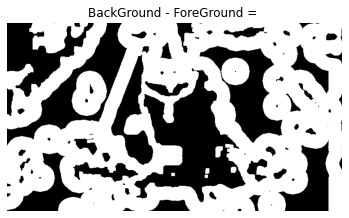

In [46]:
unknown = cv2.subtract(sure_background, sure_foreground)

plt.figure(), plt.title("BackGround - ForeGround = "), plt.imshow(unknown, cmap="gray"), plt.axis("off");

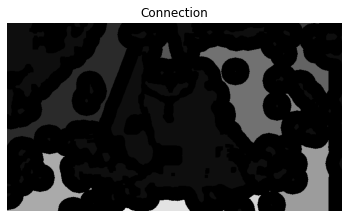

In [47]:
ret, marker = cv2.connectedComponents(sure_foreground)

marker = marker + 1

marker[unknown == 255] = 0 # White area is turned into Black to find island for watershed

plt.figure(), plt.title("Connection"), plt.imshow(marker, cmap="gray"), plt.axis("off");


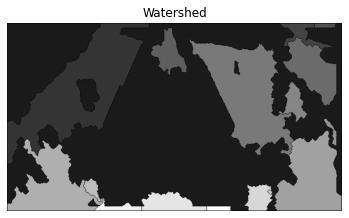

In [48]:
marker = cv2.watershed(image=coin, markers=marker)

plt.figure(), plt.title("Watershed"), plt.imshow(marker, cmap="gray"), plt.axis("off");

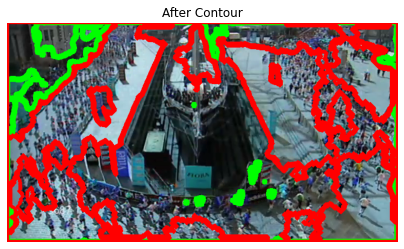

In [49]:
contour, hierarchy = cv2.findContours(image=marker.copy(), mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contour)):
    
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(image=coin,contours=contour,contourIdx=i, color=(255,0,0), thickness=3)
        
plt.figure(figsize=(7,7)), plt.title("After Contour"), plt.imshow(coin, cmap="gray"), plt.axis("off");
